# 11: Using Xarray to look at Daymet precipitation around Mt. Rainier
In this example, we'll use [xarray](http://xarray.pydata.org/en/stable/why-xarray.html) to load and process a [NetCDF](https://www.unidata.ucar.edu/software/netcdf/) file of gridded precipitation data from the [Daymet model](https://daymet.ornl.gov/overview). Xarray aims to make working with multi-dimensional data easier, by implementing labeling of indices (e.g., to allow arrays to be indexed or sliced based on x and y coordinates or time, similar to what pandas does for tabular data).

<img src="http://xray.readthedocs.org/en/stable/_images/dataset-diagram.png" alt="Drawing" style="width: 600px;"/>

Next, we'll explore some of the extended geospatial functionality of the [rioxarray](https://github.com/corteva/rioxarray/tree/master) extension.

Note that there is also a [UXarray package](https://uxarray.readthedocs.io/en/latest/index.html) in early development that provides xarray-like functionality for unstructured grids.

**Datasets:**
* Gridded precipitation output from the [Daymet model](https://daymet.ornl.gov/overview), for 1980-2018, for the area around Mt. Rainier.
* An elevation raster for the area around Mt. Rainier, created in the `gis_raster_mt_rainier_glaciers.ipynb` exercise.

**Xarray operations:**
* make a `DataArray` from scratch (using the `DataArray()` constructor)
* load a NetCDF dataset into an `xarray.DataSet` instance
* plotting the NetCDF data in projected or geographic coordinates
* getting values at point locations
* coordinate transformations
* slicing in time and space
* boolean slicing
* computing monthly averages using `groupby`
* outputting extracted timeseries to pandas DataFrames
* subsetting the xarray dataset and saving to a NetCDF file

**rioxarray operations:**
* add coordinate reference information to a dataset
* reproject a dataset
* write one or more (2D) timeslices of a dataset to a raster
* clip a dataset to a polygon feature

**References:**
* The [Xarray manual](http://xarray.pydata.org/en/stable/why-xarray.html)
* [Xarray in 45 minutes](https://tutorial.xarray.dev/overview/xarray-in-45-min.html)
* The [GeoHackWeek tutorials](https://github.com/geohackweek/tutorial_contents/tree/master/nDarrays/notebooks)
* [this tutorial from Columbia University](https://rabernat.github.io/research_computing/xarray.html)

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import rasterio
from rasterio.plot import show
import xarray as xr
from pyproj import Transformer
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource

# for elevation hillshade if we want to use it
ls = LightSource(azdeg=315, altdeg=45)

## Xarray

### DataArrays
The basic data structure in xarray is the DataArray, analogous to a Series in pandas. Data Arrays store data for a single variable, and can be any number of dimensions. Below is a simple example of a 1D DataArray.

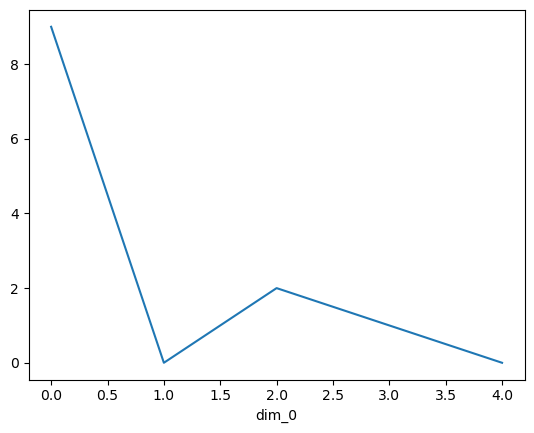

In [2]:
da = xr.DataArray([9, 0, 2, 1, 0])
da.plot()

#### Assigning names to the dimensions
(and naming the variable)

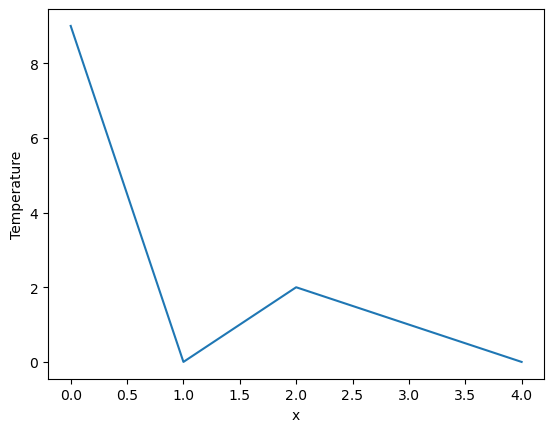

In [3]:
da = xr.DataArray([9, 0, 2, 1, 0], dims=['x'], name='Temperature')
da.plot()

### Coordinates
The real power of Xarray is being able to specify coordinates for each data point (e.g. in x, y, z, time), and then index or slice the data using those coordinates, like in pandas

In [4]:
da = xr.DataArray([9, 0, 2, 1, 0],
                  dims=['x'], coords={'x': [10, 20, 30, 40, 50]},
                  name='Temperature')
da

<xarray.DataArray 'Temperature' (x: 5)> Size: 40B
array([9, 0, 2, 1, 0])
Coordinates:
  * x        (x) int64 40B 10 20 30 40 50

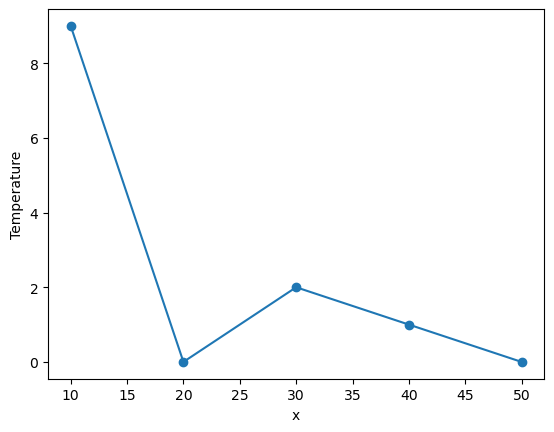

In [5]:
da.plot(marker='o')

In [6]:
da.loc[:20]

<xarray.DataArray 'Temperature' (x: 2)> Size: 16B
array([9, 0])
Coordinates:
  * x        (x) int64 16B 10 20

As in pandas, we can slice the data using ranges of coordinate values, but for syntax we need to pass a ``slice`` object to the dimension name. As in Pandas (and different from base python or Numpy), the end value of the slice is included.

In [7]:
da.sel(x=slice(30,50)) 

<xarray.DataArray 'Temperature' (x: 3)> Size: 24B
array([2, 1, 0])
Coordinates:
  * x        (x) int64 24B 30 40 50

## Datasets
A Dataset holds multiple DataArrays, analogous to a DataFrame in pandas housing multiple Series. Like in Pandas, the different DataArrays can share coordinates, and they can be assigned variable names (analogous to column names). The graphic at the beginning of this lesson shows a Dataset with precipitation, temperature, latitude and longitude DataArrays.

A Dataset can be created from a DataArray with the `.to_dataset()` method:

In [8]:
ds = da.to_dataset()

Additional DataArrays can then be added:

In [9]:
ds['precip'] = xr.DataArray(3 * np.array([.5, 0., 0., .1, 0.]), dims=['x'])

A Dataset can also be generated from scratch:  
(this example taken from the Xarray documentation)

In [10]:
temp = 15 + 8 * np.random.randn(2, 2, 3)

precip = 10 * np.random.rand(2, 2, 3)

lon = [[-99.83, -99.32], [-99.79, -99.23]]

lat = [[42.25, 42.21], [42.63, 42.59]]

ds = xr.Dataset(
    {
        "temperature": (["x", "y", "time"], temp),
        "precipitation": (["x", "y", "time"], precip),
    },
    coords={
        "lon": (["x", "y"], lon),
        "lat": (["x", "y"], lat),
        "time": pd.date_range("2014-09-06", periods=3),
        "reference_time": pd.Timestamp("2014-09-05"),
    },
)



### inputs
* [Daymet](https://daymet.ornl.gov/overview) gridded precipitation estimates for area around Mt. Rainier, 1980-2018. Obtained via the [Daymet Tile Selection Tool](https://daymet.ornl.gov/gridded/)
* a [proj string](https://proj.org/usage/quickstart.html) for Daymet could be created from the [dataset description](https://daymet.ornl.gov/overview); however, it was easier to just copy it from [here](http://rpubs.com/tbiggs/GEOG576_EX3_DAYMET)
* a 30 m DEM of elevations around Mt. Rainier, in geographic coordinates, created in the `gis_raster_mt_rainier_glaciers.ipynb` exercise

In [11]:
daymet_prcp_data = 'data/xarray/daymet_prcp_rainier_1980-2018.nc'
daymet_proj_string = ('+proj=lcc +lon_0=-100 +lat_0=42.5 +x_0=0 +y_0=0 '
                      '+lat_1=25 +lat_2=60 +ellps=WGS84')
mt_rainier_elevations = 'data/xarray/aligned-19700901_ned1_2003_adj_4269.tif'

### Load the Mt. Rainier precipitation dataset

**Note:** Datasets spanning multiple files can also be loaded using the [`xr.open_mfdataset()`](http://xarray.pydata.org/en/stable/generated/xarray.open_mfdataset.html) constructor (requires the [Dask](https://dask.org/) package). The beauty of xarray's load methods is that they are [lazy](https://en.wikipedia.org/wiki/Lazy_loading), meaning the dataset is scanned to gain an understanding of its contents, but the actual data isn't loaded into memory until it is actually needed. This allows one to work on very large (10s or 100s of GB) datasets that wouldn't fit into memory.

In [12]:
ds = xr.load_dataset(daymet_prcp_data)
ds

<xarray.Dataset> Size: 53MB
Dimensions:                  (time: 14235, y: 31, x: 30, nv: 2)
Coordinates:
    lat                      (y, x) float64 7kB 46.96 46.97 ... 46.76 46.76
    lon                      (y, x) float64 7kB -122.0 -122.0 ... -121.5 -121.5
  * x                        (x) float64 240B -1.581e+06 ... -1.552e+06
  * y                        (y) float64 248B 6.83e+05 6.82e+05 ... 6.53e+05
  * time                     (time) datetime64[ns] 114kB 1980-01-01T12:00:00 ...
Dimensions without coordinates: nv
Data variables:
    lambert_conformal_conic  (time) int16 28kB -32767 -32767 ... -32767 -32767
    yearday                  (time) int16 28kB 0 1 2 3 4 ... 360 361 362 363 364
    prcp                     (time, y, x) float32 53MB nan 15.0 15.0 ... 0.0 0.0
    time_bnds                (time, nv) datetime64[ns] 228kB 1980-01-01 ... 2...
Attributes:
    tileid:            12270
    start_year:        1980
    source:            Daymet Software Version 3.0
    Version_software:  Daymet Software Version 3.0
    Version_data:      Daymet Data Version 3.0
    Conventions:       CF-1.6
    citation:          Please see http://daymet.ornl.gov/ for current Daymet ...
    references:        Please see http://daymet.ornl.gov/ for current informa...

#### Access the precipitation variable

In [13]:
ds['prcp']

<xarray.DataArray 'prcp' (time: 14235, y: 31, x: 30)> Size: 53MB
array([[[nan, 15., 15., ..., 15., 12., 13.],
        [15., 16., 16., ..., 15., 13., 14.],
        [15., 16., 17., ..., 16., 14., 14.],
        ...,
        [20., 18., 17., ..., 14., 18., 18.],
        [20., 20., 18., ..., 15., 17., 19.],
        [22., 20., 21., ..., 15., 16., 17.]],

       [[nan,  6.,  6., ...,  8.,  7.,  8.],
        [ 5.,  6.,  6., ...,  8.,  7.,  8.],
        [ 5.,  5.,  6., ...,  9.,  7.,  8.],
        ...,
        [ 8.,  6.,  6., ...,  4.,  7.,  7.],
        [ 8.,  8.,  7., ...,  5.,  7.,  8.],
        [ 9.,  8.,  8., ...,  5.,  6.,  7.]],

       [[nan, 11., 11., ..., 13., 12., 13.],
        [11., 11., 11., ..., 13., 12., 13.],
        [11., 11., 12., ..., 14., 12., 13.],
        ...,
...
        [30., 28., 26., ..., 20., 24., 24.],
        [30., 30., 28., ..., 21., 24., 25.],
        [32., 30., 31., ..., 20., 22., 23.]],

       [[nan, 14., 13., ..., 18., 13., 15.],
        [14., 15., 14., ..., 18., 15., 17.],
        [15., 15., 16., ..., 20., 16., 17.],
        ...,
        [24., 22., 21., ..., 16., 20., 20.],
        [24., 24., 22., ..., 17., 19., 20.],
        [25., 24., 24., ..., 16., 18., 18.]],

       [[nan,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 3.,  2.,  1., ...,  0.,  0.,  0.],
        [ 3.,  4.,  2., ...,  0.,  0.,  0.],
        [ 5.,  4.,  4., ...,  0.,  0.,  0.]]],
      shape=(14235, 31, 30), dtype=float32)
Coordinates:
    lat      (y, x) float64 7kB 46.96 46.97 46.97 46.97 ... 46.76 46.76 46.76
    lon      (y, x) float64 7kB -122.0 -122.0 -122.0 ... -121.5 -121.5 -121.5
  * x        (x) float64 240B -1.581e+06 -1.58e+06 ... -1.553e+06 -1.552e+06
  * y        (y) float64 248B 6.83e+05 6.82e+05 6.81e+05 ... 6.54e+05 6.53e+05
  * time     (time) datetime64[ns] 114kB 1980-01-01T12:00:00 ... 2018-12-31T1...
Attributes:
    long_name:     daily total precipitation
    units:         mm/day
    grid_mapping:  lambert_conformal_conic
    cell_methods:  area: mean time: sum

#### make a quick plot of the mean precipitation through time (1980-2018) at each pixel (data point)

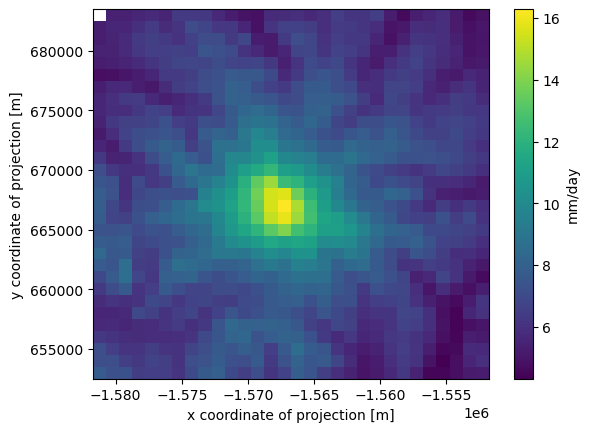

In [14]:
ds.prcp.mean(dim='time').plot(cbar_kwargs={'label': ds['prcp'].units})

### what if we want to plot the data in geographic coordinates?
we can use the attached `DataArray.plot.pcolormesh` method, which wraps `pyplot.pcolormesh`. `pcolormesh` takes grids of x and y values corresponding to each position in the array to be plotted. The attached xarray method just requires us to specify the label indices with the x and y values.

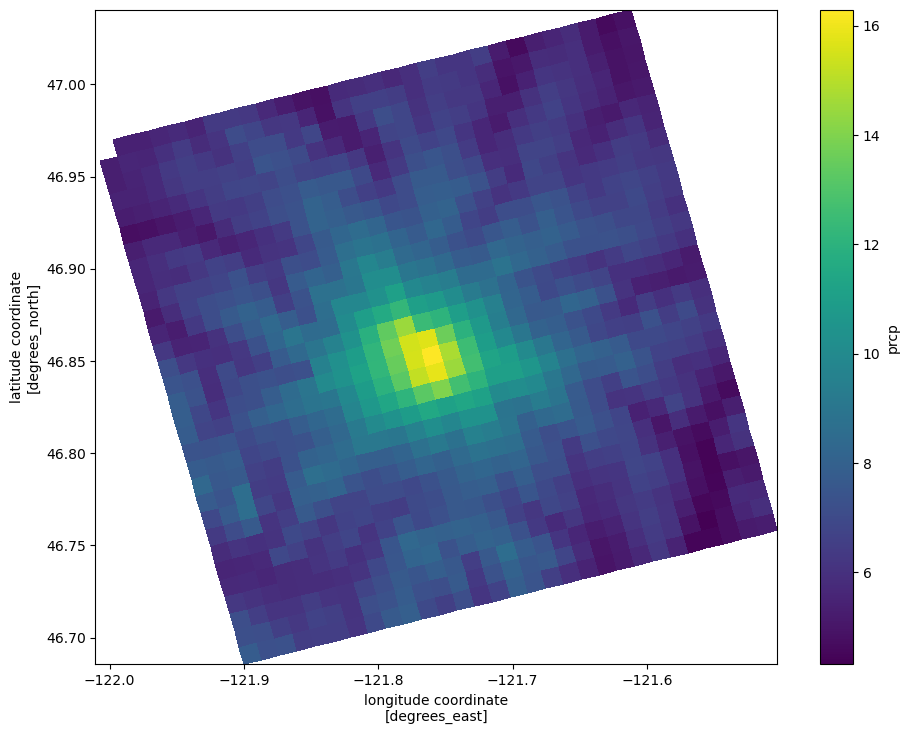

In [15]:
fig, ax = plt.subplots(figsize=(11, 8.5))
qm = ds.prcp.mean(dim='time').plot.pcolormesh('lon', 'lat', rasterized=True)

### Let's add some topography for reference

Load the elevation data with `rasterio`, get the bounding extent, and `rasterio.show` to quickly plot the data with its coordinates (instead of row, column locations)

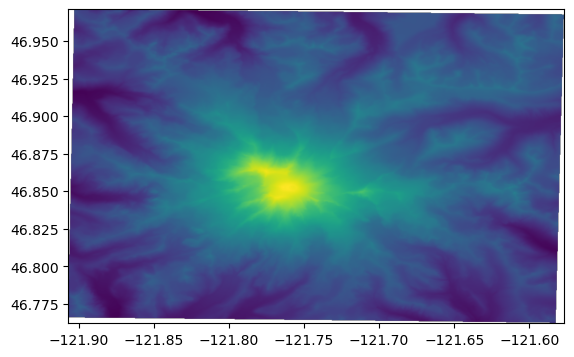

In [16]:
with rasterio.open(mt_rainier_elevations) as src:
    elev_bounds = src.bounds
    # reorder the rasterio bounds for pyplot
    elev_extent = (elev_bounds[0], elev_bounds[2], 
                   elev_bounds[1], elev_bounds[3])
    elevations = src.read(1)
    show(src)

### Overlay the mean precip. values on the topography
* use the `matplotlib` `LightSource.hillshade` method to convert the elevations to a shaded relief raster
    * assign `zorder=-1` to ensure that the data plot on the bottom
* plot mean precip, but specify `alpha < 1` so that it has some transparency; the colorbar can be controlled with `cbar_kwargs` (arguments that are passed to the `matplotlib` colorbar constructor)
* set the plot limits to the extent of the elevation raster (`*` unpacks list elevations into individual arguments)

(-121.90692427970113, -121.57658593832609)

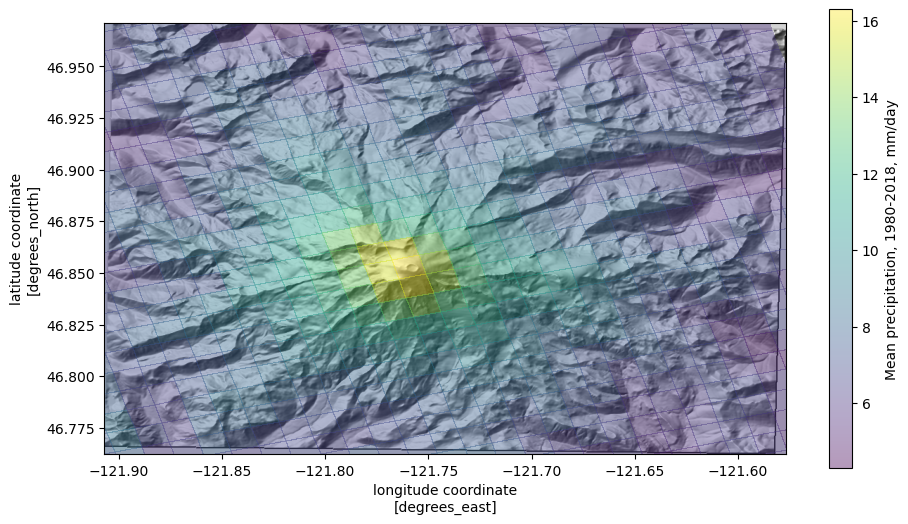

In [17]:
fig, ax = plt.subplots(figsize=(11, 8.5))
ax.imshow(ls.hillshade(elevations, vert_exag=0.1), cmap='gray', extent=elev_extent, 
          zorder=-1)
cbar_kwargs={'shrink': 0.7,
             'label': f"Mean precipitation, 1980-2018, {ds['prcp'].units}"}
qm = ds.prcp.mean(dim='time').plot.pcolormesh('lon', 'lat', 
                                              rasterized=True, 
                                              #linewidth=0, 
                                              alpha=0.4, 
                                              cbar_kwargs=cbar_kwargs)
ax.set_ylim(*elev_extent[2:])
ax.set_xlim(*elev_extent[:2])

### Getting data at point locations

Say we want to get data for the mountain summit, and at the Paradise Visitor Center in Mt. Rainier National Park.
We can easily get the lat, lon coordinates for these locations, but to get data from this dataset, we need to work in the [custom coordinate system for Daymet](https://daymet.ornl.gov/overview). Luckily, we found a PROJ string to define that, which we assigned to the variable `daymet_proj_string`. With the PROJ string, we can use `pyproj` to transform the coordinates to the Daymet CRS.

In [18]:
coords = {'summit': (46.852886, -121.760374),
          'paradise': (46.7868, -121.7338)}

transformer = Transformer.from_crs(4269, daymet_proj_string)
coords_lcc = {k: transformer.transform(*v) for k, v in coords.items()}
coords_lcc

{'summit': (-1567320.5383531058, 667030.7252830392),
 'paradise': (-1567257.837050381, 659751.1451685613)}

#### plot the two locations

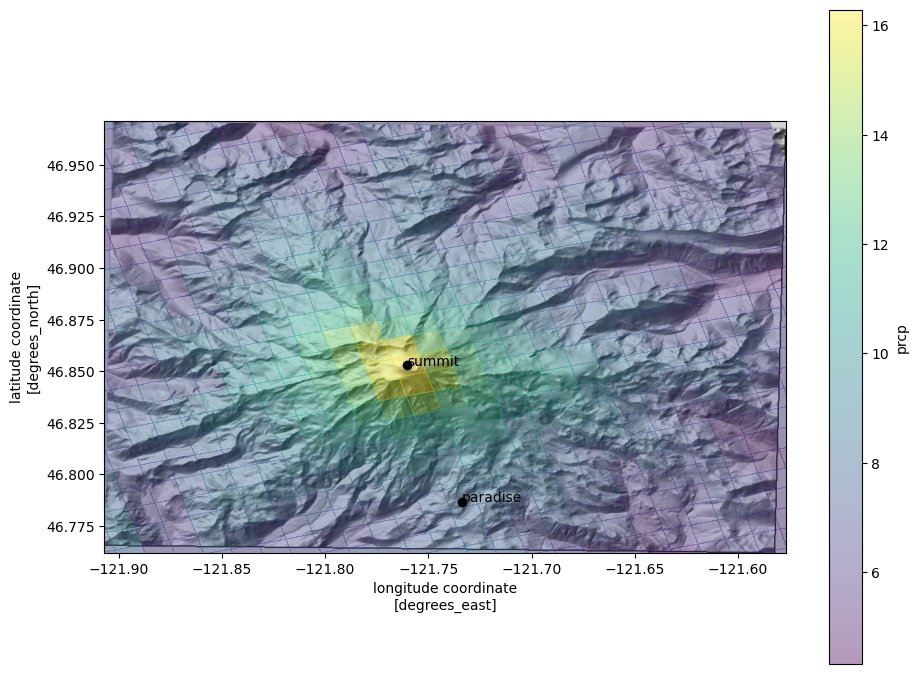

In [19]:
fig, ax = plt.subplots(figsize=(11, 8.5))
ax.imshow(ls.hillshade(elevations, vert_exag=0.1), cmap='gray', extent=elev_extent, 
          zorder=-1)
qm = ds.prcp.mean(dim='time').plot.pcolormesh('lon', 'lat', 
                                              rasterized=True, 
                                              #linewidth=0, 
                                              alpha=0.4)
ax.set_ylim(*elev_extent[2:])
ax.set_xlim(*elev_extent[:2])
for label, (y, x) in coords.items():
    ax.scatter(x, y, c='k')
    ax.text(x, y, label, transform=ax.transData)

### Get a time series of precip values at the nearest pixel to the summit

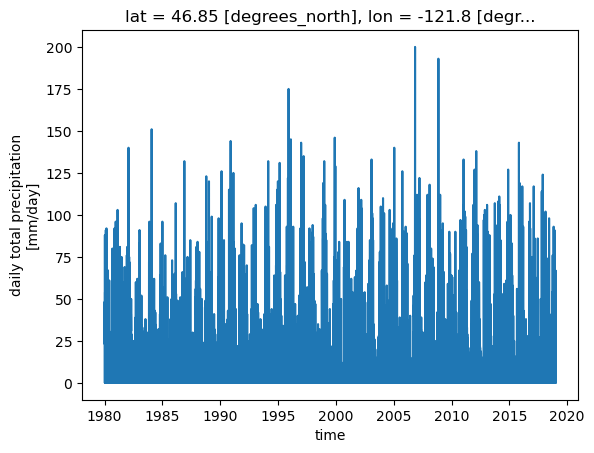

In [20]:
x, y = coords_lcc['summit']
ds.prcp.sel(x=[x], y=[y], method='nearest').plot()

### we can also slice along the time axis
But to do that, we need to chain the operation (instead of including the `time=` argument in the first call to `DataArray.sel()`)

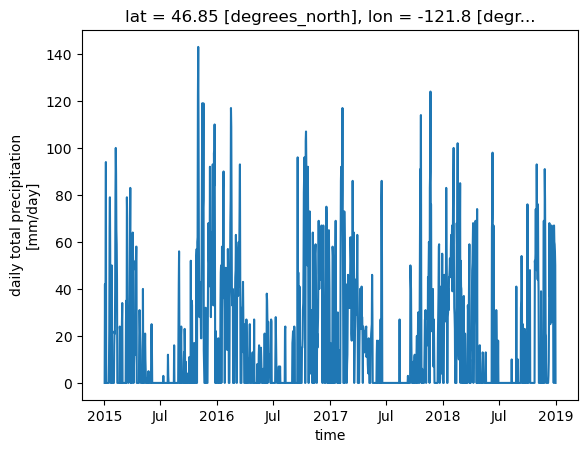

In [21]:
ds.prcp.sel(x=[x], y=[y], method='nearest').sel(time=slice('2015', '2018')).plot()

### slicing the whole dataset in time

Taking getting the mean value for 2012 (note, we could also simply write `time=slice('2012')`

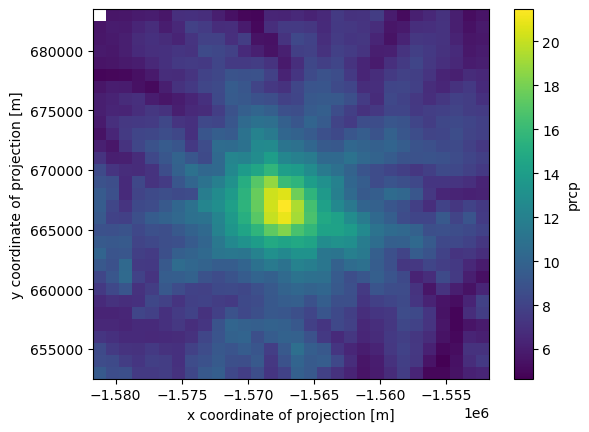

In [22]:
ds.prcp.sel(time=slice('2012-01-01', '2012-12-31')).mean(axis=0).plot()

### making a 2D slice spatially

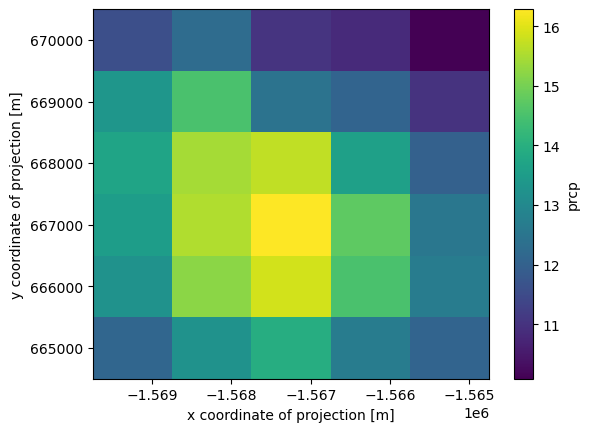

In [23]:
ds.prcp.sel(x=slice(-1570000, -1565000), y=slice(670000, 665000)).mean(axis=0).plot()

### what if we want to slice by latitude and longitude
The projected coordinate system that this dataset is aligned with is not aligned with latitude and longitude, so the lat and lon coordinates associated with each pixel are 2D.

In [24]:
ds.lat.shape

(31, 30)

### boolean slicing
In other words, a box aligned with latitude and longitude will be rotated in the native CRS. Therefore we have to either specify explicitly what lat, lon values we want, or we can use a boolean slice. Let's say we want all of the pixels between 46.8 and 46.9 N, and -121.8 and -121.7 longitude.

In [25]:
valid_lat = (ds['lat'].values > 46.8) & (ds['lat'].values < 46.9)
valid_lon = (ds['lon'].values > -121.8) & (ds['lon'].values < -121.7)

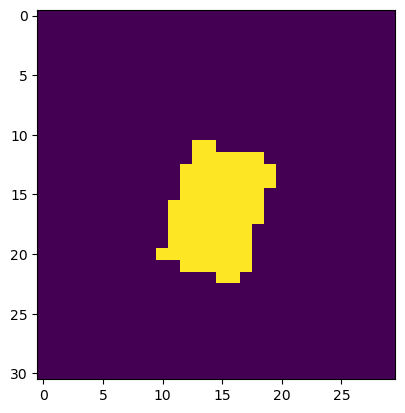

In [26]:
plt.imshow(valid_lat&valid_lon)

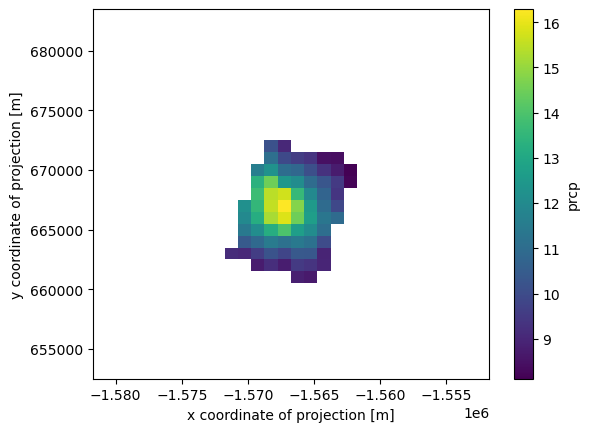

In [27]:
ds.prcp.loc[:].where(valid_lat&valid_lon).mean(axis=0).plot()

### Writing out subsetted data to new netcdf file
The above boolean indexing only masks the pixels that evaluated to `False`. Oftentimes, we want to subset a large dataset to only include the area we are working in.

#### drop the rows and columns that have all nans

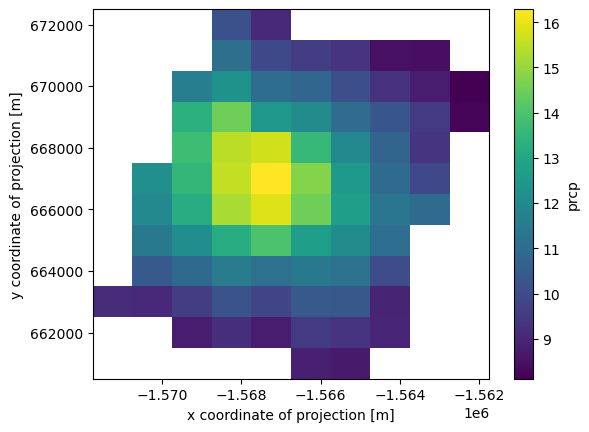

In [28]:
prcp_subset = ds.prcp.loc[:].where(valid_lat&valid_lon)
prcp_subset = prcp_subset.dropna(dim='x', how='all').dropna(dim='y', how='all')
prcp_subset.mean(axis=0).plot()

#### write it out to a netcdf file
* use encoding to reduce the resulting file size

further reading on compression:
https://unidata.github.io/netcdf4-python/#efficient-compression-of-netcdf-variables

In [29]:
# make an output folder first
output_folder = Path('11-output')
output_folder.mkdir(exist_ok=True)

encoding={'prcp': {'zlib': True, # compression algorithm
                     'complevel': 4, # compression level
                     'dtype': 'float32',
                     '_FillValue': -9999,
                     }}

prcp_subset.to_netcdf(output_folder / 'rainier_prcp_subset.nc',
                     encoding=encoding)

### Groupby
* more in [the xarray manual](http://xarray.pydata.org/en/stable/groupby.html)
* also note that `groupby()` operations can be slow. The [flox project](https://github.com/xarray-contrib/flox) is aiming to speed groupby operations.

#### getting monthly values

In [30]:
ds.prcp.groupby('time.month').mean(dim='time').shape

(12, 31, 30)

### monthy mean precipitation for the whole dataset, in mm/day

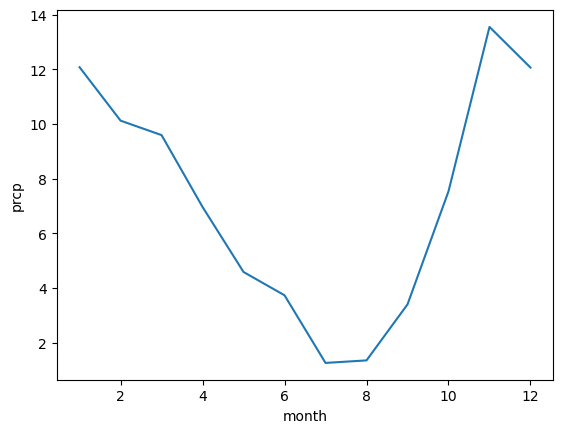

In [31]:
ds.prcp.groupby('time.month').mean(dim='time').mean(axis=(1, 2)).plot()

### annual precip for whole dataset, in feet

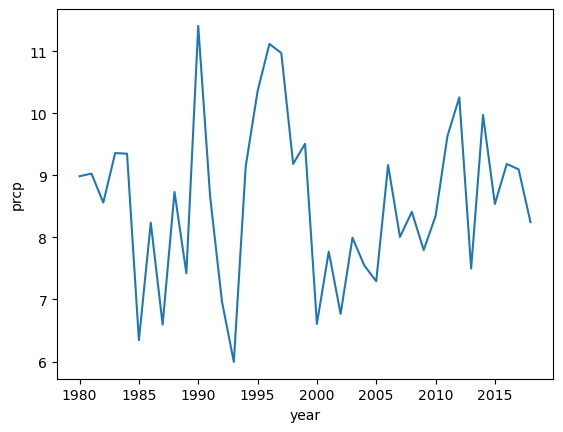

In [32]:
annual_precip = ds.prcp.groupby('time.year').sum(dim='time')/304.8
annual_precip.mean(axis=(1, 2)).plot()

### comparing precip at the summit vs. Paradise

In [33]:
coords_lcc

{'summit': (-1567320.5383531058, 667030.7252830392),
 'paradise': (-1567257.837050381, 659751.1451685613)}

#### convert to feet per month
by multiplying by 30.4, the average number of days in a month. This is just for the sake of simplicity in this exercise. A better way to do this would be to multiply by an array with the number of days in each month.

In [34]:
prcp_monthly_mean_ft = ds.prcp.groupby('time.month').mean(dim='time') * (30.4/304.8)

#### Note that in the winter, these values represent snow-water equivalent, not snowfall
During the winter of 1971-1972, Paradise set the world record for snowfall, with 1,122 inches (93.5 ft, 28.5 m)
It was later broken by Mt. Baker, where 1,140 inches (95 feet) was recorded at the Mt. Baker Ski Area during the 1998-1999 season. Annual average snowfall at Paraside is 54.6 feet for the period of 1916-2016

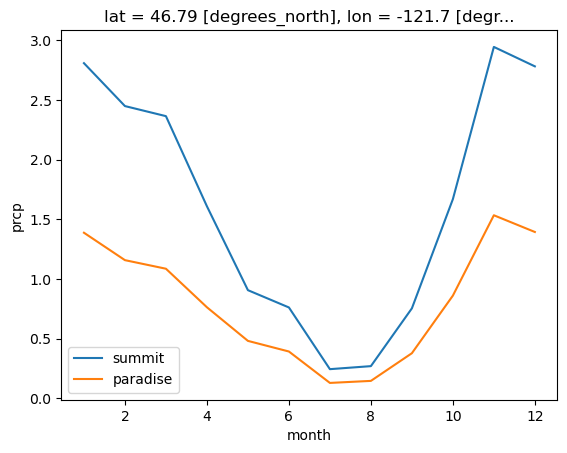

In [35]:
fig, ax = plt.subplots()
for site in ['summit', 'paradise']:
    prcp_site = prcp_monthly_mean_ft.sel(x=coords_lcc[site][0], 
                                         y=coords_lcc[site][1],
                                         method='nearest')
    prcp_site.plot(label=site)
    ax.legend()

#### Compare annual precip

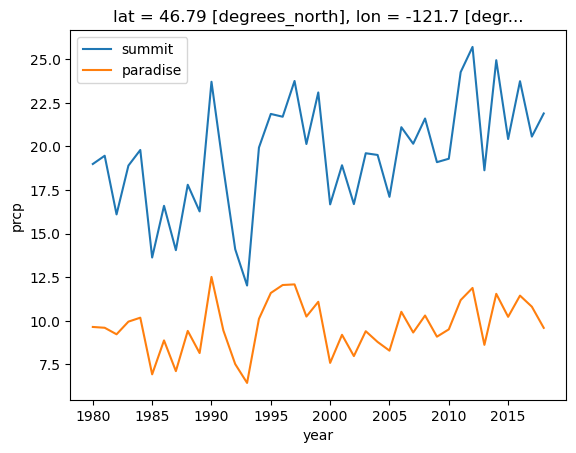

In [36]:
fig, ax = plt.subplots()
for site in ['summit', 'paradise']:
    prcp_site = annual_precip.sel(x=coords_lcc[site][0], 
                                         y=coords_lcc[site][1],
                                         method='nearest')
    prcp_site.plot(label=site)
    ax.legend()

### plot maps of average monthly precip with topopgraphy

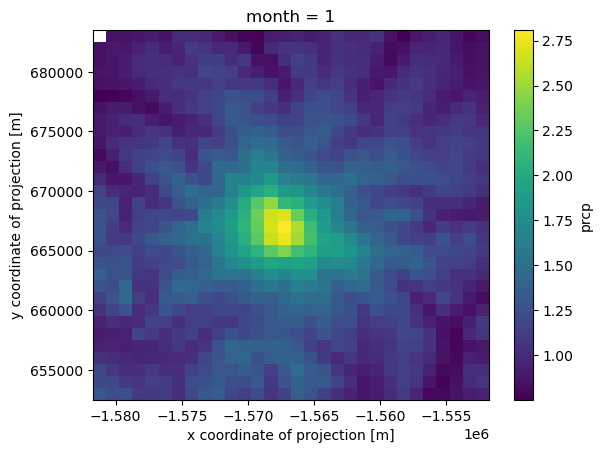

In [37]:
prcp_monthly_mean_ft.loc[1].plot()

The `prcp_monthly_mean_ft` DataArray we created above is grouped by month. Months are on the 0 axis, which ranges from 1 to 12.

In [38]:
prcp_monthly_mean_ft['month']

<xarray.DataArray 'month' (month: 12)> Size: 96B
array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])
Coordinates:
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12

### compare January and August

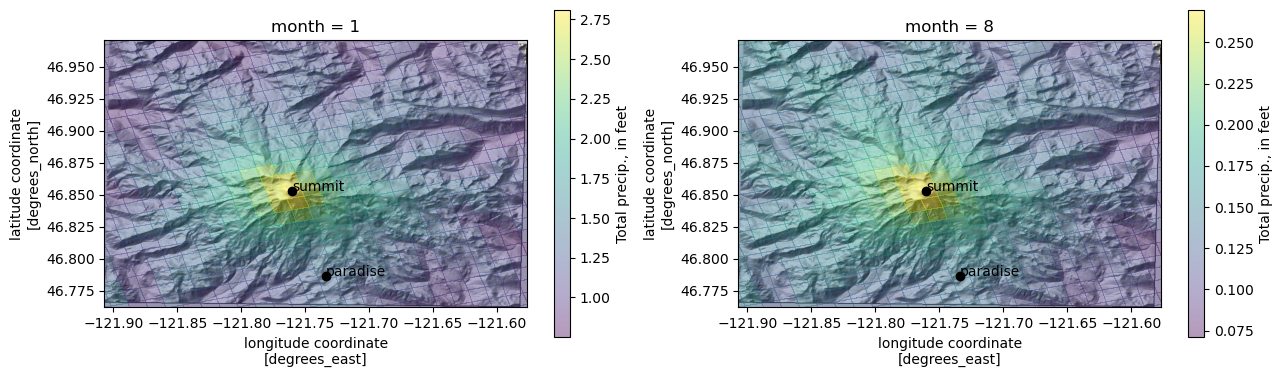

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(15, 8.5))
months = [1, 8]

for i, ax in enumerate(axes.flat):
    month = months[i]
    ax.imshow(ls.hillshade(elevations, vert_exag=0.1), cmap='gray', extent=elev_extent, 
              zorder=-1)
    qm = prcp_monthly_mean_ft.loc[month].plot.pcolormesh(
        'lon', 'lat', rasterized=True, #linewidth=0, 
        alpha=0.4, ax=ax, 
        cbar_kwargs={"shrink": 0.5, 
                     "label": "Total precip., in feet"}
        )
    ax.set_ylim(*elev_extent[2:])
    ax.set_xlim(*elev_extent[:2])
    for label, (y, x) in coords.items():
        ax.scatter(x, y, c='k')
        ax.text(x, y, label, transform=ax.transData)

### what if we just want to get a timeseries of values at each point of interest, in a pandas DataFrame?

#### first make lists of the x and y values, and a corresponding list of site names

In [40]:
sites = ['summit', 'paradise']
x = []
y = []
for key in sites:
    x.append(coords_lcc[key][0])
    y.append(coords_lcc[key][1])
x, y

([-1567320.5383531058, -1567257.837050381],
 [667030.7252830392, 659751.1451685613])

For each site, make the selection. Drop the indices we don't need, and convert the resulting DataArray to a pandas DataFrame with the `to_dataframe()` method. Append each dataframe to a list and then concatenate them into a single DataFrame (`axis=1` specifies that the DataFrames should be concatenated along the column axis)

In [41]:
dfs = []
for i, site in enumerate(sites):
    df = ds.prcp.sel(x=x[0], 
                     y=y[0],
                     method='nearest').drop(['lat', 'lon', 'x', 'y']).to_dataframe()
    df.columns = [site]
    dfs.append(df)

df = pd.concat(dfs, axis=1)

/tmp/ipykernel_7166/2018086405.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  method='nearest').drop(['lat', 'lon', 'x', 'y']).to_dataframe()
/tmp/ipykernel_7166/2018086405.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  method='nearest').drop(['lat', 'lon', 'x', 'y']).to_dataframe()


In [42]:
df.head()

,summit,paradise
time,,
1980-01-01 12:00:00,48.0,48.0
1980-01-02 12:00:00,24.0,24.0
1980-01-03 12:00:00,31.0,31.0
1980-01-04 12:00:00,23.0,23.0
1980-01-05 12:00:00,48.0,48.0


## rioxarray
Xarray focuses on operations within a dataset, or between datasets in the same coordinate reference system (CRS). It does not keep track of coordinate reference information or do any transformations.

[rioxarray](https://github.com/corteva/rioxarray/tree/master) is an extension for xarray that provides additional geospatial functionality, including coordinate transformations, intersections with other geospatial features including polygons, and writing arrays to rasters. It uses [rasterio](https://github.com/rasterio/rasterio) and [pyproj](https://github.com/pyproj4/pyproj) to do this.


In [43]:
import rioxarray

### Setting coordinate reference information
Most operations with rioxarray require a coordinate reference. In this case, we have a [PROJ string](https://proj.org/en/9.3/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems) that we got from the DayMet website, and coordinate reference information embedded in the dataset.

We can set the coordinate reference by calling `.rio.write_crs()` on the Xarray object, which writes coordinate reference information to the Xarray dataset in a [CF compliant](https://cfconventions.org/Data/cf-documents/requirements-recommendations/conformance-1.11.html) manner. Similar to pandas, a copy is returned, or we can set the coordinate reference in-place.

In [44]:
ds.rio.write_crs(daymet_proj_string, inplace=True)

<xarray.Dataset> Size: 53MB
Dimensions:                  (time: 14235, y: 31, x: 30, nv: 2)
Coordinates:
    lambert_conformal_conic  int64 8B 0
    lat                      (y, x) float64 7kB 46.96 46.97 ... 46.76 46.76
    lon                      (y, x) float64 7kB -122.0 -122.0 ... -121.5 -121.5
  * x                        (x) float64 240B -1.581e+06 ... -1.552e+06
  * y                        (y) float64 248B 6.83e+05 6.82e+05 ... 6.53e+05
  * time                     (time) datetime64[ns] 114kB 1980-01-01T12:00:00 ...
Dimensions without coordinates: nv
Data variables:
    yearday                  (time) int16 28kB 0 1 2 3 4 ... 360 361 362 363 364
    prcp                     (time, y, x) float32 53MB nan 15.0 15.0 ... 0.0 0.0
    time_bnds                (time, nv) datetime64[ns] 228kB 1980-01-01 ... 2...
Attributes:
    tileid:            12270
    start_year:        1980
    source:            Daymet Software Version 3.0
    Version_software:  Daymet Software Version 3.0
    Version_data:      Daymet Data Version 3.0
    Conventions:       CF-1.6
    citation:          Please see http://daymet.ornl.gov/ for current Daymet ...
    references:        Please see http://daymet.ornl.gov/ for current informa...

#### Setting the coordinate reference from information in the NetCDF dataset
**Note:** this is often specific to the individual dataset! In this case, we have a number of parameters that may be sufficient to define a CRS. The [pyproj](https://github.com/pyproj4/pyproj) package provides a `CRS` object that allows coordinate reference information to be robustly defined so that it can be used for transformations.

In [45]:
ds['lambert_conformal_conic']

<xarray.DataArray 'lambert_conformal_conic' ()> Size: 8B
array(0)
Coordinates:
    lambert_conformal_conic  int64 8B 0
Attributes: (12/17)
    crs_wkt:                        PROJCS["unknown",GEOGCS["unknown",DATUM["...
    semi_major_axis:                6378137.0
    semi_minor_axis:                6356752.314245179
    inverse_flattening:             298.257223563
    reference_ellipsoid_name:       WGS 84
    longitude_of_prime_meridian:    0.0
    ...                             ...
    standard_parallel:              (25.0, 60.0)
    latitude_of_projection_origin:  42.5
    longitude_of_central_meridian:  -100.0
    false_easting:                  0.0
    false_northing:                 0.0
    spatial_ref:                    PROJCS["unknown",GEOGCS["unknown",DATUM["...

In [46]:
from pyproj import CRS

daymet_crs = CRS.from_cf(ds['lambert_conformal_conic'].attrs)
daymet_crs

<Projected CRS: PROJCS["unknown",GEOGCS["unknown",DATUM["Unknown b ...>
Name: unknown
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Lambert Conic Conformal (2SP)
Datum: Unknown based on WGS 84 ellipsoid
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [47]:
ds.rio.write_crs(daymet_crs, inplace=True)

<xarray.Dataset> Size: 53MB
Dimensions:                  (time: 14235, y: 31, x: 30, nv: 2)
Coordinates:
    lat                      (y, x) float64 7kB 46.96 46.97 ... 46.76 46.76
    lon                      (y, x) float64 7kB -122.0 -122.0 ... -121.5 -121.5
  * x                        (x) float64 240B -1.581e+06 ... -1.552e+06
  * y                        (y) float64 248B 6.83e+05 6.82e+05 ... 6.53e+05
  * time                     (time) datetime64[ns] 114kB 1980-01-01T12:00:00 ...
    lambert_conformal_conic  int64 8B 0
Dimensions without coordinates: nv
Data variables:
    yearday                  (time) int16 28kB 0 1 2 3 4 ... 360 361 362 363 364
    prcp                     (time, y, x) float32 53MB nan 15.0 15.0 ... 0.0 0.0
    time_bnds                (time, nv) datetime64[ns] 228kB 1980-01-01 ... 2...
Attributes:
    tileid:            12270
    start_year:        1980
    source:            Daymet Software Version 3.0
    Version_software:  Daymet Software Version 3.0
    Version_data:      Daymet Data Version 3.0
    Conventions:       CF-1.6
    citation:          Please see http://daymet.ornl.gov/ for current Daymet ...
    references:        Please see http://daymet.ornl.gov/ for current informa...

### Reprojecting the dataset
Here we reproject the dataset into geographic coordinates (Lat/Lon). We can use the spatial reference ID 4269 (an [EPSG code](https://www.linkedin.com/pulse/whats-epsg-how-do-i-use-salina-morrow#:~:text=The%20EPSG%20number%20is%20a,that%20can%20display%20those%20files.)) to specify the destination coordinate reference system (geographic coordinates with the NAD83 datum).

Note that this dataset already includes `lat`/`lon` coordinates. Because the x and y axes are in a projected coordinate reference system (Lambert Conformal Conic), the `lat`/`lon` coordinates are two dimensional (each point in the dataset has its own `lat`/`lon` coordinate). **`rioxarray`** doesn't like this for some reason-- as of version 0.15, it produces a `ValueError: IndexVariable objects must be 1-dimensional` when we try to reproject. To get around this, we can drop the `lat`/`lon` coordinates before calling `.rio.project()`.

In [48]:
ds_4269 = ds['prcp'].drop_vars(['lat', 'lon']).rio.reproject(4269)

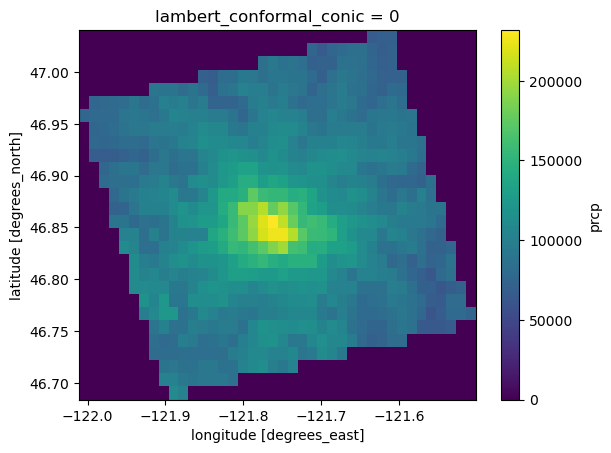

In [49]:
ax = ds_4269.sum(axis=0).plot()

### Write an xarray dataset to a raster

Write part of the dataset out to a GeoTIFF. 

Earlier versions of rioxarray require us to remove the `'grid_mapping'` attribute first (at least in version 0.15, you will get an error otherwise). `grid_mapping` is a variable from the original NetCDF dataset that specifies that coordinate reference information is contained in a variable called `'lambert_conformal_conic'` (we used it above to specify the coordinate reference information for **rioxarray**).

#### Write a single 2D timeslice to a raster

In [50]:
precip_slice = ds.sel(time='2018-12-30')['prcp']

# remove grid_mapping if needed
#del precip_slice.attrs['grid_mapping']

In [51]:
precip_slice.rio.to_raster(output_folder / 'pcrp_20181230.tif')

#### writing a 3D array (of multiple times) to a multi-band raster
In this case, each day from 12/25 to 12/30 is written it a separate band.

In [52]:
precip_slice = ds.sel(time=slice('2018-12-25', '2018-12-30'))['prcp']

precip_slice.rio.to_raster(output_folder / 'pcrp_20181225-30.tif')

### Clip to a shapefile area
Sometimes we may want to clip a dataset to a geographic area defined by a polygon shapefile. We can read a shapefile into a GeoDataFrame using `geopandas`. In this case, we'll just use the glacier polygons from the [Rasterio: Mt. Rainier glaciers example](https://github.com/DOI-USGS/python-for-hydrology/blob/main/notebooks/part0_python_intro/10_Rasterio.ipynb).

In [53]:
import geopandas as gpd

gdf = gpd.read_file("data/rasterio/rgi60_glacierpoly_rainier.shp")
gdf.head()

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Aspect,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,geometry
0,RGI60-02.14393,G238292E46809N,19709999,19949999,-121.70769,46.80930,2,4,0.126,2001,...,148,397,0,0,0,0,0,9,Williwakas Glacier WA,"POLYGON ((-121.70642 46.80792, -121.7065 46.80..."
1,RGI60-02.14394,G238275E46811N,19709999,19949999,-121.72504,46.81055,2,4,0.010,2207,...,222,-9,0,0,0,0,0,9,WA,"POLYGON ((-121.72552 46.80985, -121.72561 46.8..."
2,RGI60-02.14395,G238235E46811N,19709999,19949999,-121.76535,46.81088,2,4,0.010,2103,...,165,-9,0,0,0,0,0,9,WA,"POLYGON ((-121.76498 46.81006, -121.76511 46.8..."
3,RGI60-02.14396,G238243E46810N,19709999,19949999,-121.75702,46.80963,2,4,0.015,2186,...,153,182,0,0,0,0,0,9,WA,"POLYGON ((-121.75659 46.80885, -121.75663 46.8..."
4,RGI60-02.14397,G238302E46809N,19709999,19949999,-121.69756,46.80850,2,4,0.012,1990,...,125,160,0,0,0,0,0,9,WA,"POLYGON ((-121.69777 46.80903, -121.6976 46.80..."


Clipping can be time-intensive, so in this case, we'll just clip all of the arrays from 2018 (n=365)

In [54]:
data = ds_4269.sel(time='2018')#.mean(axis=0)

The `invert` argument specifies whether we want to only include data pixels within the clip feature(s), or outside of the clip feature(s). 

In [55]:
clipped = data.rio.clip(gdf['geometry'].values, gdf.crs, drop=False, invert=False)
clipped

<xarray.DataArray 'prcp' (time: 365, y: 28, x: 40)> Size: 2MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]],
      shape=(365, 28, 40), dtype=float32)
Coordinates:
  * x                        (x) float64 320B -122.0 -122.0 ... -121.5 -121.5
  * y                        (y) float64 224B 47.03 47.02 47.01 ... 46.7 46.69
  * time                     (time) datetime64[ns] 3kB 2018-01-01T12:00:00 .....
    lambert_conformal_conic  int64 8B 0
Attributes:
    long_name:     daily total precipitation
    units:         mm/day
    cell_methods:  area: mean time: sum

#### Plot the clipped data on top of the original clip features

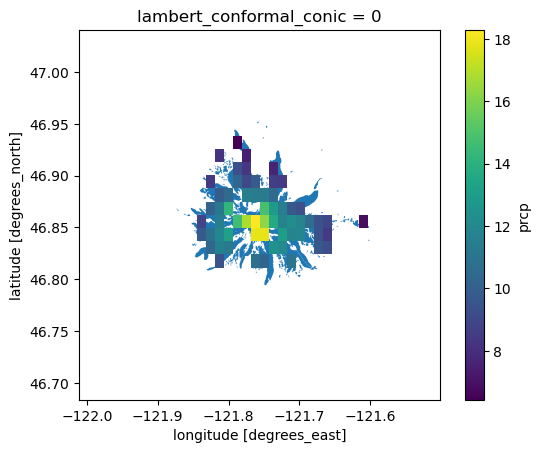

In [56]:
fig, ax = plt.subplots()
gdf.plot(ax=ax)
clipped.mean(axis=0).plot(ax=ax)